In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import itertools
from sklearn.preprocessing import StandardScaler
import backtrader as bt
import pyfolio as pf
import math
from utils import *
%matplotlib inline

In [46]:
train_length = 500
test_length = 20
return_day = 20

In [47]:
pred = pd.read_csv(f'pred/prediction_{train_length}_{test_length}_{return_day}.csv', index_col='Date', parse_dates=True)
pred.head()

,0
Date,
2001-05-25,Neg
2001-05-29,Neg
2001-05-30,Neutral
2001-05-31,Neutral
2001-06-01,Neutral


In [38]:
class TestStrategy(BaseStrategy):
    def __init__(self):
        self.buys = []
        self.sells = []
        self.last = None
        
    def canceled(self):
        if self.last == 'Pos':
            del self.buys[-1]
        else:
            del self.sells[-1]
        
    def next(self):
        date_to_look_for = self.data.datetime.datetime(0)
        try:
            predicted_dir = pred.loc[date_to_look_for].iloc[0]
        except:
            predicted_dir = None
        
        if predicted_dir == 'Pos':
            self.log('Long prediction')
            self.buy(exectype=bt.Order.Market)
            self.buys.append(self.data.datetime.datetime(return_day))
        if (len(self.buys) > 0) and (date_to_look_for >= self.buys[0]):
            self.log('Close long')
            self.sell(exectype=bt.Order.Market)
            del self.buys[0]
            print(f'\tBuys length changed to {len(self.buys)}')
            
#         if predicted_dir == 'Neg':
#             self.log('Short prediction')
#             self.sell(exectype=bt.Order.Market)
#             self.sells.append(self.data.datetime.datetime(return_day))
#         if (len(self.sells) > 0) and (date_to_look_for >= self.sells[0]):
#             self.log('Close short')
#             self.buy(exectype=bt.Order.Market)
#             del self.sells[0]
#             print(f'\tSells length changed to {len(self.buys)}')
            
        self.last = predicted_dir

In [39]:
cerebro = bt.Cerebro()
cerebro.addstrategy(TestStrategy)

data = bt.feeds.PandasData(dataname=read_ami_SPY_data(), fromdate=pred.index[0])

cerebro.adddata(data)
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.broker.set_coc(True)
cerebro.addsizer(bt.sizers.SizerFix, stake=20)
# cerebro.addsizer(bt.sizers.PercentSizer, percents=1)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
results = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

Starting Portfolio Value: 100000.00
2001-06-20, Long prediction
2001-06-21, BUY EXECUTED, 122.43
2001-06-21, Long prediction
2001-06-22, BUY EXECUTED, 123.82
2001-07-09, Long prediction
2001-07-10, BUY EXECUTED, 119.70
2001-07-10, Long prediction
2001-07-11, BUY EXECUTED, 118.26
2001-07-11, Long prediction
2001-07-12, BUY EXECUTED, 118.38
2001-07-13, Long prediction
2001-07-16, BUY EXECUTED, 122.24
2001-07-16, Long prediction
2001-07-17, BUY EXECUTED, 120.71
2001-07-17, Long prediction
2001-07-18, BUY EXECUTED, 121.84
2001-07-18, Long prediction
2001-07-19, BUY EXECUTED, 121.01
2001-07-19, Close long
	Buys length changed to 8
2001-07-20, SELL EXECUTED, 122.07
2001-07-20, Long prediction
2001-07-20, Close long
	Buys length changed to 8
2001-07-23, BUY EXECUTED, 121.34
2001-07-23, SELL EXECUTED, 121.34
2001-07-25, Long prediction
2001-07-26, BUY EXECUTED, 119.10
2001-08-06, Close long
	Buys length changed to 8
2001-08-07, SELL EXECUTED, 120.30
2001-08-07, Close long
	Buys length changed 

In [40]:
# transactions

Entire data start date: 2002-03-26
Entire data end date: 2018-01-18
Backtest months: 189


,Backtest
Annual return,1.3%
Cumulative returns,23.0%
Annual volatility,4.3%
Sharpe ratio,0.33
Calmar ratio,0.10
Stability,0.42
Max drawdown,-12.9%
Omega ratio,1.08
Sortino ratio,0.47
Skew,0.22


C:\DEV\Anaconda3\envs\trading\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,12.89,2007-10-09,2009-03-09,2014-02-27,1668
1,5.48,2015-12-29,2016-02-11,2016-11-09,227
2,5.32,2015-05-21,2015-09-28,2015-10-22,111
3,4.06,2002-04-16,2002-07-23,2003-10-10,389
4,3.78,2007-07-19,2007-08-15,2007-10-01,53


C:\DEV\Anaconda3\envs\trading\lib\site-packages\pyfolio\plotting.py:819: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  bmark_vol = factor_returns.loc[returns.index].std()
C:\DEV\Anaconda3\envs\trading\lib\site-packages\seaborn\categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


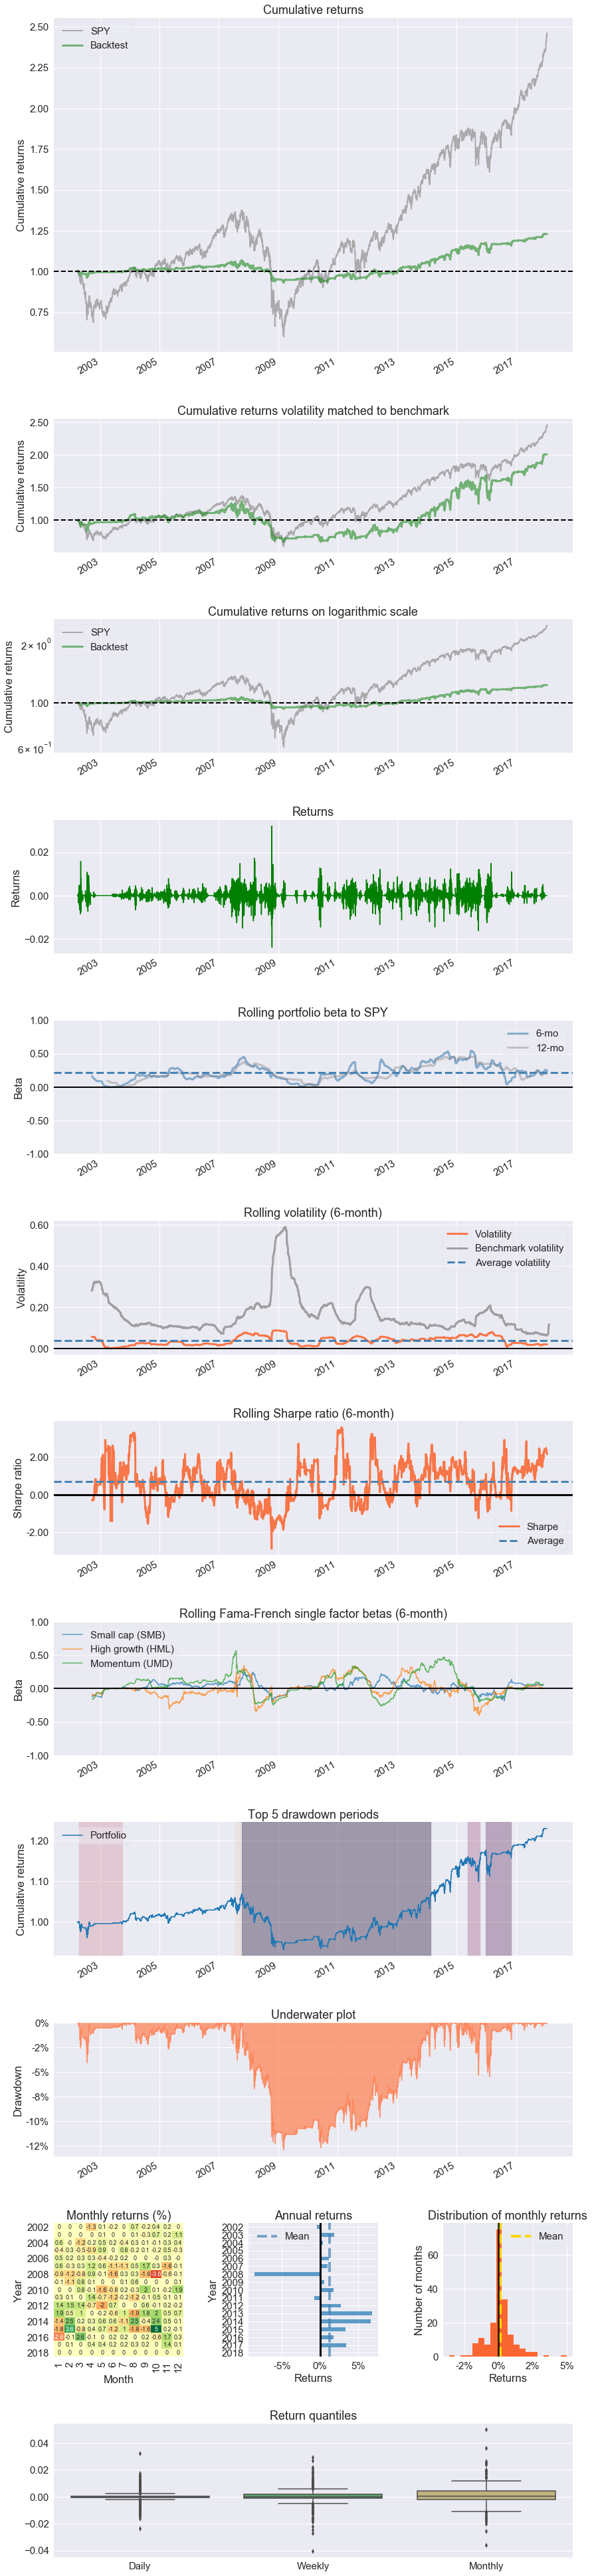

Stress Events,mean,min,max
Lehmann,-0.03%,-0.90%,0.59%
9/11,0.08%,-0.23%,0.71%
US downgrade/European Debt Crisis,-0.01%,-0.95%,0.64%
Fukushima,0.04%,-0.63%,0.52%
US Housing,0.00%,0.00%,0.00%
EZB IR Event,-0.00%,-0.33%,0.64%
Aug07,0.02%,-1.26%,0.81%
Mar08,0.01%,-1.02%,1.72%
Sept08,-0.07%,-0.90%,0.56%
2009Q1,-0.03%,-0.37%,0.30%


KeyError: '9/11'

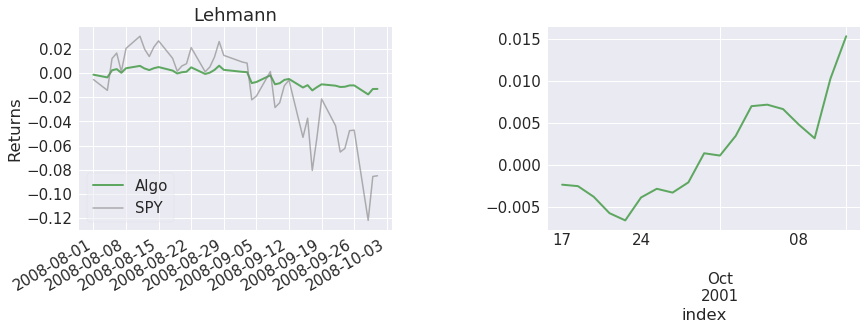

In [41]:
pf.create_full_tear_sheet(returns=returns, 
                          positions=positions, 
                          transactions=transactions,
                          round_trips=True)